## The influence of waves and bubbles on oxygen in the ocean interior

This notebook reproduces the figures shown in Rustogi et al. (submitted) to ERL special edition: "Focus on Breathless Oceans: Understanding and Addressing Marine Oxygen Loss Across Scales"

==========================

Authors: Paridhi Rustogi, Laure Resplandy, Seth Bushinksy and Luc Deike

Creation Date: March 11, 2025



In [1]:
#==========Load dependencies 
%config InlineBackend.figure_format = 'retina'  
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes 

import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "cmr10"
plt.rcParams["axes.formatter.use_mathtext"] = True  #
plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 12

pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

from scipy import stats
from datetime import datetime, timedelta
from dask.diagnostics import ProgressBar
import time, os, warnings, cftime, cmocean

# Cartopy
import cartopy as cp
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings("ignore")

# ======== Custom Colormaps
colors = ['orangered','orange', 'seashell', 'skyblue', 'dodgerblue']
cmap_flux = LinearSegmentedColormap.from_list('custom_flux', colors, N=22)

colors = ['darkred','orange','seashell', 'skyblue','navy']
cmap_dflux = LinearSegmentedColormap.from_list('custom_flux', colors, N=22)

import xesmf as xe

In [8]:
#==========
delta_z_values = np.array([ 5., 10., 10., 15., 22.5, 25., 25., 25., 37.5,
                            50., 50., 75., 100., 100., 100., 100., 100., 100.,
                            100., 100., 100., 100., 175., 250., 375., 500.,
                            500., 500., 500., 500., 500., 500., 500., 500., 500.])

z_l_values = np.array([ 2.5 ,   10.  ,   20.  ,   32.5 ,   51.25,   75.  ,  100.  ,  125.  ,
                        156.25,  200.  ,  250.  ,  312.5 ,  400.  ,  500.  ,  600.  ,  700.  ,
                        800.  ,  900.  , 1000.  , 1100.  , 1200.  , 1300.  , 1400.  , 1537.5 ,
                        1750.  , 2062.5 , 2500.  , 3000.  , 3500.  , 4000.  , 4500.  , 5000.  ,
                        5500.  , 6000.  , 6500.  ])

delta_z = xr.DataArray(delta_z_values, coords={"z_l": z_l_values}, dims=["z_l"],
    attrs={"description": "Delta z", "units": "m"})

masks = xr.open_dataset('data_for_results/RECCAP2_region_masks_all_v20221025.nc')
with xr.open_dataset('data_for_results/hist_gcb_w14_ocean_static.nc') as ds:
        area   = ds.area_t.load() # yh:576 xh:720   
        area_wet = ds.wet.load()
        geolon = ds.geolon  
        geolat = ds.geolat
        depth = ds.depth_ocean
    
        
ds_out = xr.Dataset({"lat": (["lat"], area.yh.values), "lon": (["lon"], area.xh.values),})

# Regrid wavefield
regridder = xe.Regridder(masks, ds_out, "nearest_s2d")
masks_r = regridder(masks)

masks_r = masks_r.rename({'lat': 'yh','lon': 'xh'})

# Open Ocean
masks_r_coast = masks_r.coast


# Open Ocean
masks_r_open_ocean = masks_r.open_ocean.where(masks_r.coast==0, 0)

# ATLANTIC
masks_r_atl = masks_r.atlantic

masks_r_atl_n = masks_r_atl.where(masks_r_atl.yh>0, 0)
masks_r_atl_s = masks_r_atl.where(masks_r_atl.yh<0, 0)

# PACIFIC
masks_r_pac = masks_r.pacific
masks_r_pac_n = masks_r_pac.where(masks_r_pac.yh>0, 0)
masks_r_pac_s = masks_r_pac.where(masks_r_pac.yh<0, 0)

# INDIAN
masks_r_ind = masks_r.indian

# ARCTIC
masks_r_arc = masks_r.arctic

# SOUTHERN
masks_r_so = masks_r.southern

# # GLOBAL (-- Arctic)
masks_r_glob = masks_r.atlantic + masks_r.pacific + masks_r.indian + masks_r.southern

# Atlantic
masks_r_so_atl = masks_r_so.where((masks_r_so.xh<30)&((masks_r_so.xh>-70)),0)
masks_r_so_atl = masks_r_so_atl + masks_r_atl

masks_r_so_atl_n = masks_r_so_atl.where(masks_r_so_atl.yh>=0, 0)
masks_r_so_atl_s = masks_r_so_atl.where(masks_r_so_atl.yh<0, 0)

# Pacific
masks_r_so_pac = masks_r_so.where((masks_r_so.xh<-70)&((masks_r_so.xh>-210)),0)
masks_r_so_pac = masks_r_so_pac + masks_r_pac

masks_r_so_pac_n = masks_r_so_pac.where(masks_r_so_pac.yh>=0, 0)
masks_r_so_pac_s = masks_r_so_pac.where(masks_r_so_pac.yh<0, 0)

# Indian
masks_r_so_ind_e = masks_r_so.where((masks_r_so.xh<-210),0)
masks_r_so_ind_w = masks_r_so.where((masks_r_so.xh>30),0)
masks_r_so_ind = masks_r_so_ind_w + masks_r_so_ind_e + masks_r_ind

# Figure 01

a) Schematic of the wind-wave-bubble oxygen flux, the sum of symmetric exchange (diffusive flux across the unbroken surface, F$_{nb}$, and large bubble contribution, F$_\mathrm{b,sym}$), and asymmetric bubble exchange (F$_\mathrm{b, asym}$, including pressurized large bubbles and small bubbles that dissolve completely). Symmetric fluxes depend on the air-sea partial pressure difference, whereas asymmetric fluxes depend on the atmospheric gas concentration and systematically lead to ocean uptake. b) Seasonal processes influencing interior oxygen. During winter, waters may remain undersaturated at formation. During summer, oxygen concentrations are modified by biological production, consumption, and ocean circulation.

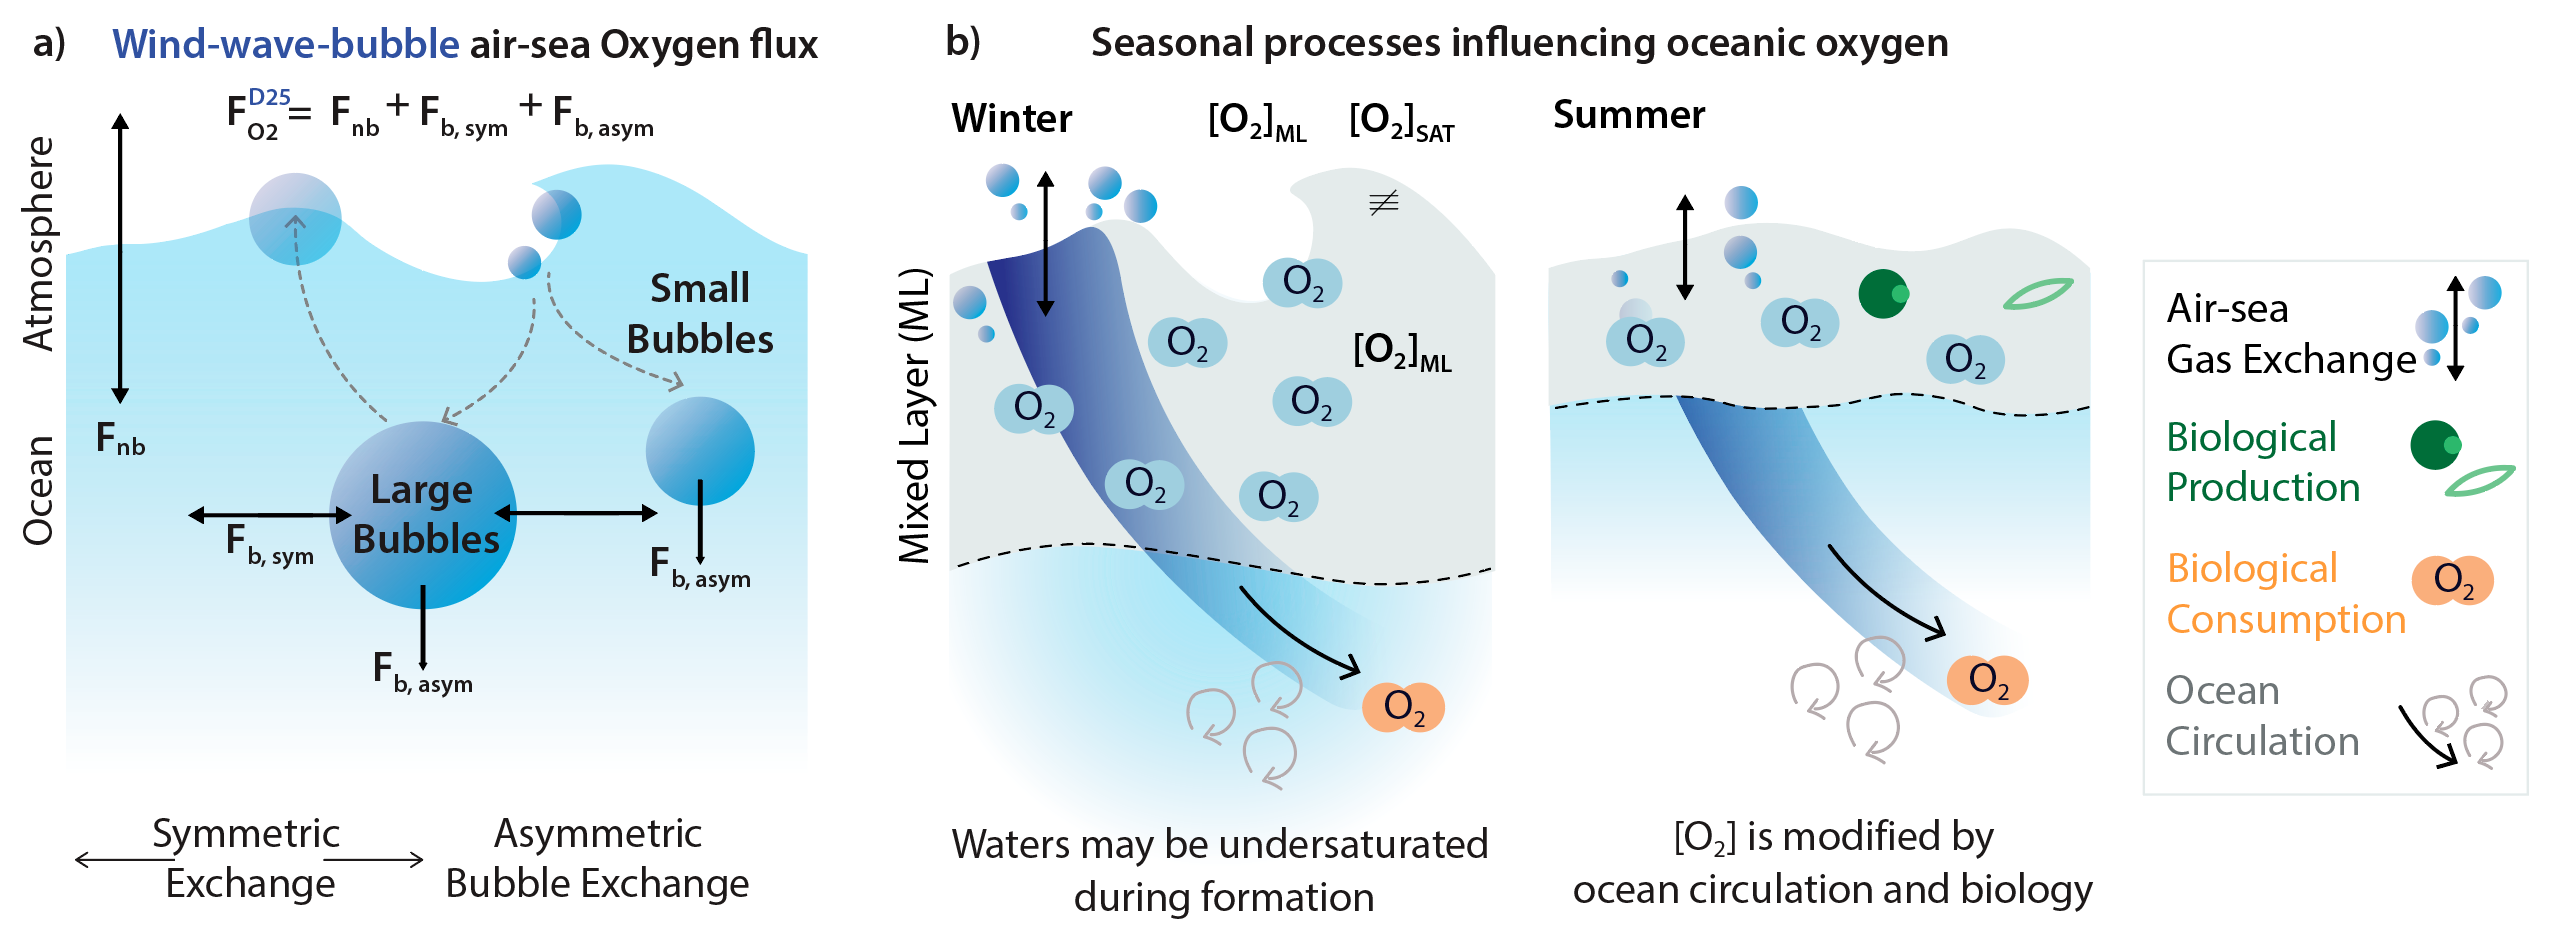

# Figure 02

Modeled seasonal air-sea O$_2$ flux and significant wave height for 1959-2020 with a, b) Total air-sea O$_2$ flux (F$_\mathrm{O2}^{D25}$) using the wind-wave-bubble formulation for the boreal fall-winter (September-February) and boreal spring-summer (March-August) periods. Positive values indicate ocean uptake (blue), and negative values indicate outgassing (orange). c, d) Flux difference compared to the wind-dependent simulation (F$_\mathrm{O2}^\mathrm{D25}$ - F$_\mathrm{O2}^\mathrm{W14}$) with the corresponding zonally integrated fluxes (Tmol O$_2$ lat$^{-1}$ yr$^{-1}$). e, f) Seasonal significant wave height (H$_s$, m) with the corresponding zonally averaged wave heights. The orange boxes highlight regions of wintertime mode and deep water mass formation.

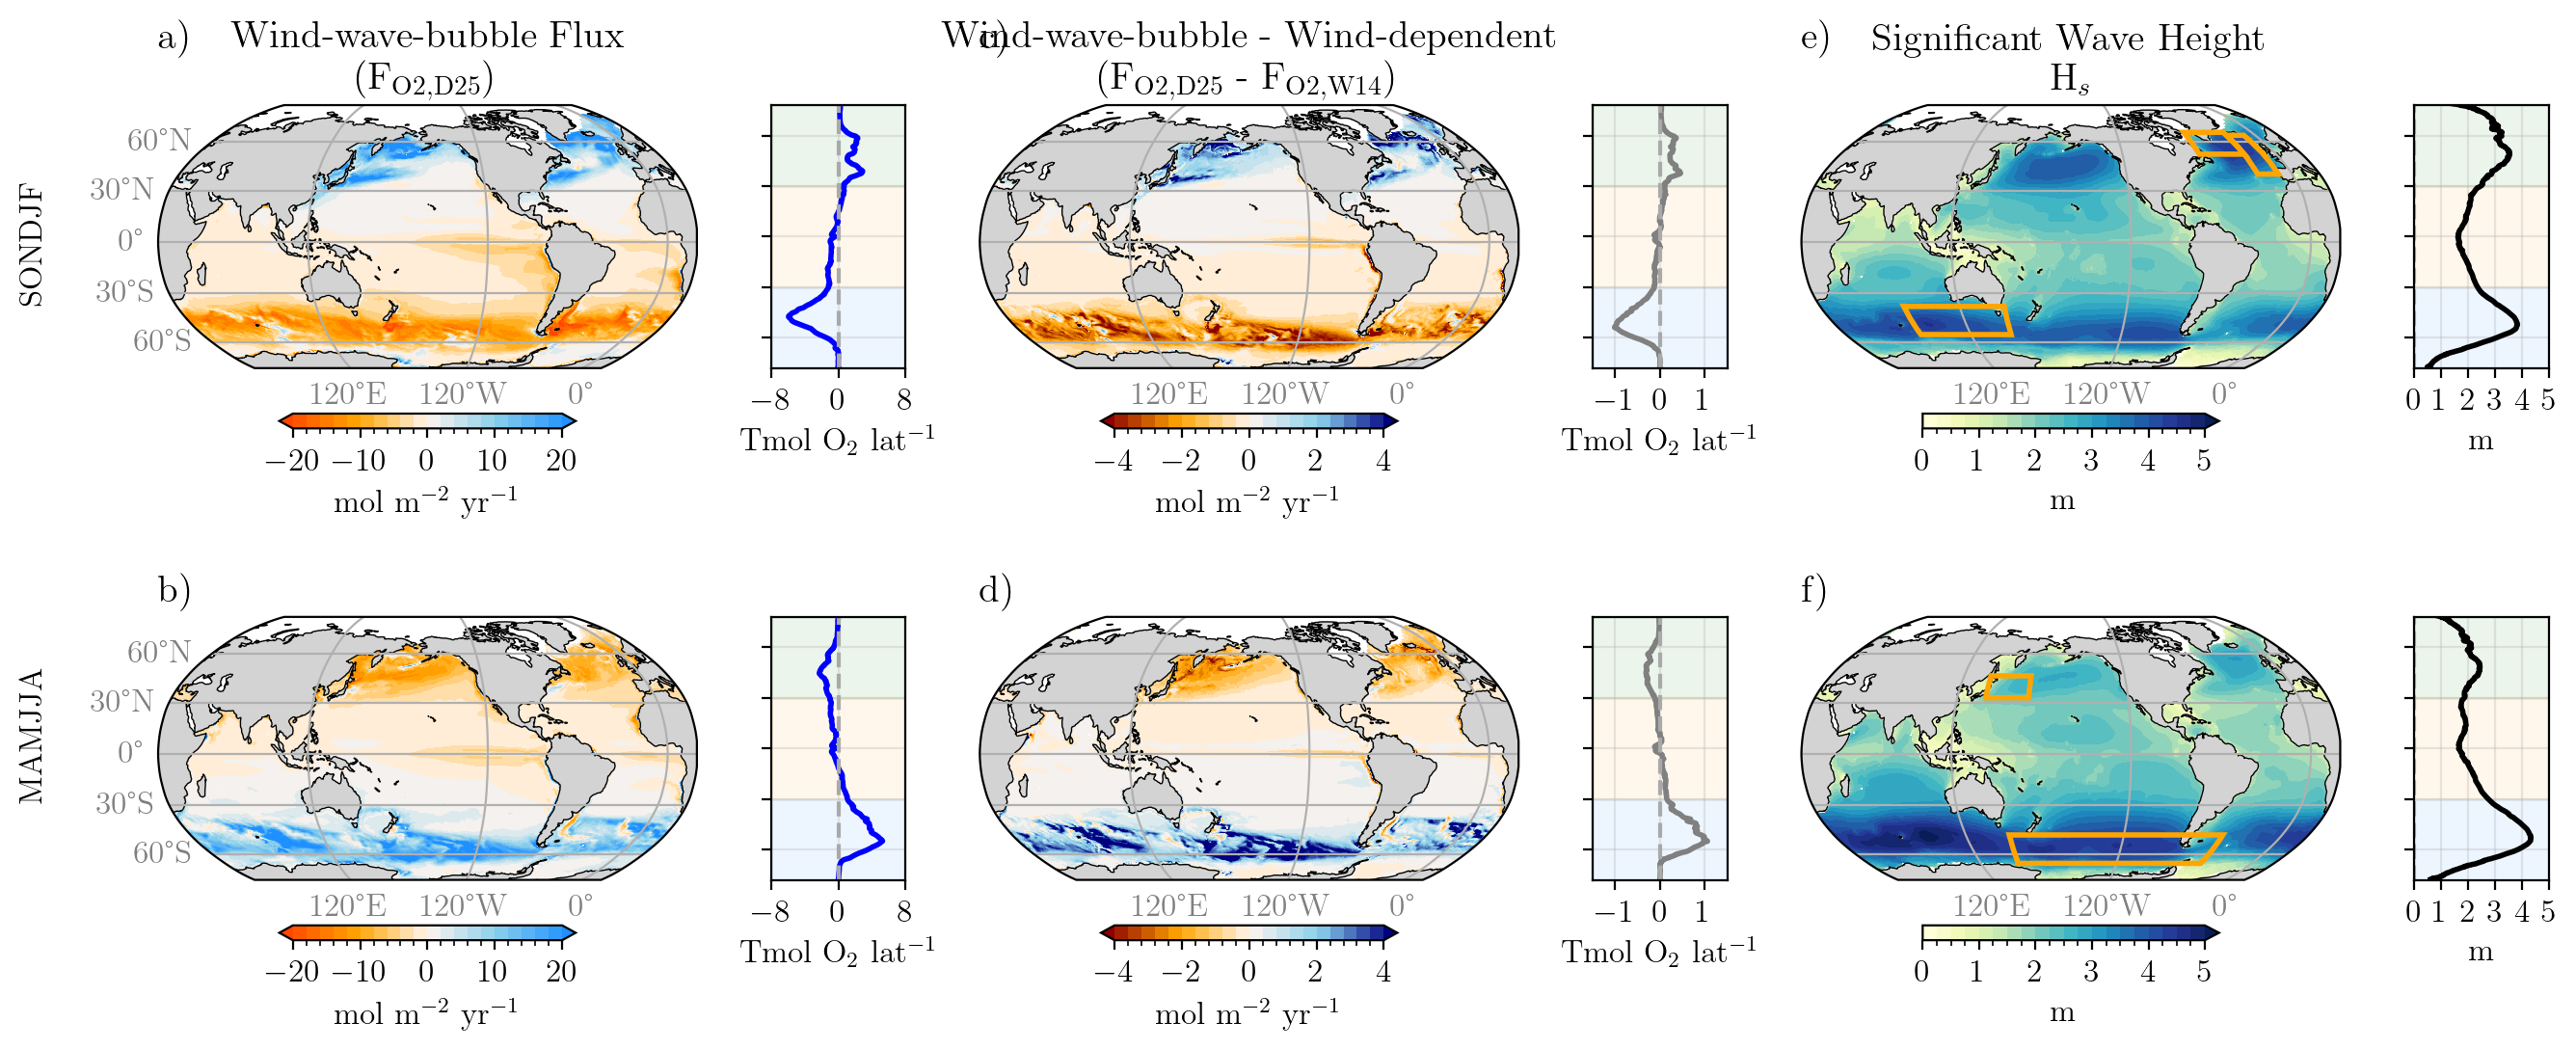

In [9]:
# Figure 2

# =========================================================
# Load data
# =========================================================

fo2_w14_seasonal = xr.open_dataset('data_for_results/fo2_W14_seasonal_1959_2020.nc')['fo2']
fo2_d25_seasonal = xr.open_dataset('data_for_results/fo2_D25_seasonal_1959_2020.nc')['fo2']

wave_mamjja_r = xr.open_dataset('data_for_results/Hs_MAMJJA_1959_2020.nc')['hs']
wave_sondjf_r = xr.open_dataset('data_for_results/Hs_SONDJF_1959_2020.nc')['hs']

# =========================================================
# Plot Figure
# =========================================================

PROJ = ccrs.Robinson(central_longitude=200)

GRIDLINE_STYLE = dict(draw_labels=True, x_inline=False, y_inline=False)

XLATS = [-120, 0, 120]
YLATS = [-60, -30, 0, 30, 60]
LABEL_STYLE = {"size": 12, "color": "gray"}
LAND = cfeature.LAND.with_scale("110m")

# =========================================================
# FO2 PANEL DATA
# =========================================================
cmaps = [cmap_flux, cmap_dflux]
vmins = [-20, -4]
vmaxs = [20, 4]
ticks = [[-20, -10, 0, 10, 20], [-4, -2, 0, 2, 4]]

panel_labels = [['a) \n', '', 'c) \n', '', 'e) \n', ''],   # Row 0
                ['b)', '', 'd)', '', 'f)', '']]    # Row 1

titles = [['Wind-wave-bubble Flux \n(F$_\mathrm{O2, D25}$)', '',
           'Wind-wave-bubble - Wind-dependent \n(F$_\mathrm{O2, D25}$ - F$_\mathrm{O2, W14}$)', '',
           'Significant Wave Height \n H$_s$', ''],
          ['', '', '', '', '', '']]
# =========================================================
# SIGNIFICANT WAVE HEIGHT DATA (COLUMN 4–5)
# =========================================================
wave_maps = [wave_sondjf_r, wave_mamjja_r]
wave_zonals = [wave_sondjf_r.where(masks_r_glob).weighted(area).mean("xh"), wave_mamjja_r.where(masks_r_glob).weighted(area).mean("xh")]

wave_cmap = "YlGnBu"
wave_vmin, wave_vmax = 0, 5
wave_ticks = np.arange(0, 6, 1)

# =========================================================
# WATER-MASS BOX DEFINITIONS
# =========================================================
wave_boxes_top = [
    (-60, -25, 52, 66, 'black'),      # NADW
    (-25, -10, 40, 64, 'black'),      # NASPMW
    (-280, -208, -55, -38, 'black')]   # IOSAMW

wave_boxes_bottom = [
    (-207, -45, -66, -48, 'black'),   # PSAMW
    (-220, -190, 33, 46, 'black')]     # NPCMW
# =========================================================
# FO2 + Δ FO2 DATA (MAPS + ZONALS)
# =========================================================

data_rows = [([fo2_d25_seasonal.sel(season="SONDJF").mean("year"),
               fo2_d25_seasonal.sel(season="SONDJF").mean("year") - fo2_w14_seasonal.sel(season="SONDJF").mean("year")],
              [(fo2_d25_seasonal.sel(season="SONDJF") * area * 1e-12).sum("xh").mean("year") / 2,
               ((fo2_d25_seasonal - fo2_w14_seasonal).sel(season="SONDJF") * area * 1e-12).sum("xh").mean("year") / 2]),
             ([fo2_d25_seasonal.sel(season="MAMJJA").mean("year"),
               fo2_d25_seasonal.sel(season="MAMJJA").mean("year") - fo2_w14_seasonal.sel(season="MAMJJA").mean("year")],
              [(fo2_d25_seasonal.sel(season="MAMJJA") * area * 1e-12).sum("xh").mean("year") / 2,
               ((fo2_d25_seasonal - fo2_w14_seasonal).sel(season="MAMJJA") * area * 1e-12).sum("xh").mean("year") / 2]),]

# =========================================================
# FIGURE LAYOUT: 2 ROWS × 6 COLUMNS
# =========================================================
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(2, 6, wspace=0.22, hspace=0.35, height_ratios=[1, 1], width_ratios=[1, 0.25, 1, 0.25, 1, 0.25])

# =========================================================
# MAIN LOOP: ROWS
# =========================================================
for r in range(2):
    maps_r, zonals_r = data_rows[r]
    map_axes, zonal_axes = [], []

    for c in range(6):
        # -------------------------------------------------
        # MAP PANELS (FO2 or WAVE)
        # -------------------------------------------------
        if c in [0, 2, 4]:

            ax = fig.add_subplot(gs[r, c], projection=PROJ)

            if c < 4:
                idx = 0 if c == 0 else 1

                maps_r[idx].where(masks_r_glob).plot(ax=ax, cmap=cmaps[idx],
                    vmin=vmins[idx], vmax=vmaxs[idx],
                    levels=np.linspace(vmins[idx], vmaxs[idx], 21), extend='both',
                    rasterized=True, transform=ccrs.PlateCarree(),
                    cbar_kwargs={'shrink': 0.55, 'orientation': 'horizontal', 'pad': 0.12, 'ticks': ticks[idx], 'label':'mol m$^{-2}$ yr$^{-1}$'})

            else:
                wave_map = wave_maps[r]
                wave_map.where(masks_r_glob).plot(ax=ax, cmap=wave_cmap,
                    vmin=wave_vmin, vmax=wave_vmax,
                    levels=np.linspace(wave_vmin, wave_vmax, 21), extend='max',
                    rasterized=True, transform=ccrs.PlateCarree(),
                    cbar_kwargs={ "shrink": 0.55, "orientation": "horizontal", "pad": 0.12, "ticks": wave_ticks, "label": "m"})

                boxes = wave_boxes_top if r == 0 else wave_boxes_bottom
                for lon_min, lon_max, lat_min, lat_max, color in boxes:
                    rect = mpatches.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                        linewidth=2, edgecolor='orange', facecolor='none', transform=ccrs.PlateCarree(), zorder=5)
                    ax.add_patch(rect)

            # Formatting for all map panels
            ax.set_title(panel_labels[r][c], loc="left", fontweight="semibold")
            ax.set_title(titles[r][c])
            ax.coastlines(linewidth=0.5)
            ax.add_feature(LAND, facecolor="lightgrey", zorder=1)

            gl = ax.gridlines(crs=ccrs.PlateCarree(), **GRIDLINE_STYLE)
            gl.top_labels = False
            gl.right_labels = False
            if c > 0:
                gl.left_labels = False

            gl.xlocator = mticker.FixedLocator(XLATS)
            gl.ylocator = mticker.FixedLocator(YLATS)
            gl.xlabel_style = LABEL_STYLE
            gl.ylabel_style = LABEL_STYLE

            map_axes.append(ax)

        # -------------------------------------------------
        # ZONAL PANELS (FO2 or WAVE)
        # -------------------------------------------------
        else:
            ax = fig.add_subplot(gs[r, c])

            # FO2 zonals
            if c < 4:
                idx = 0 if c == 1 else 1
                dd = zonals_r[idx]
                color = "blue" if idx == 0 else "grey"

            # Wave zonals
            else:
                dd = wave_zonals[r]
                color = "black"

            ax.plot(dd, dd.yh, color=color, linewidth=2)
            ax.axvline(0, linestyle="--", color="darkgrey")

            # shaded latitude bands
            ax.axhspan(-30, 30, color="orange", alpha=0.08)
            ax.axhspan(-80, -30, color="dodgerblue", alpha=0.08)
            ax.axhspan(30, 80, color="green", alpha=0.08)

            ax.set_ylim(-78, 78)

            if c == 5:   # wave zonal scale
                ax.set_xlim(0, 5)
                ax.set_xticks(np.arange(0, 6, 1))
                ax.set_xlabel("m")

            else:        # FO2 zonal scales
                if c == 1:
                    ax.set_xlim(-8, 8)
                    ax.set_xticks([-8, 0, 8])
                else:
                    ax.set_xlim(-1.5, 1.5)
                    ax.set_xticks([-1, 0, 1])
                ax.set_xlabel("Tmol O$_2$ lat$^{-1}$")

            ax.grid(alpha=0.3)

            # y axis formatting
            ax.set_yticks([-60, -30, 0, 30, 60])
            ax.set_yticklabels([])
            zonal_axes.append(ax)

    # ----------------------------------------
    # Match zonal-panel height to map height
    # ----------------------------------------
    ref_box = map_axes[0].get_position()
    for ax in zonal_axes:
        box = ax.get_position()
        ax.set_position([box.x0, ref_box.y0, box.width, ref_box.height])
# ----------------------------------------
# Row labels
# ----------------------------------------
fig.text(0.08, 0.7, "SONDJF", rotation="vertical", fontsize=12)
fig.text(0.08, 0.27, "MAMJJA", rotation="vertical", fontsize=12)
plt.tight_layout()
plt.show()

# Figure 3

Modeled and observed winter mixed layer oxygen undersaturation during water mass formation. a) Spatial distribution of median column undersaturation (\%) during winter formation for the wind-wave-bubble simulation (D25), highlighting regions used for analysis of mode and deep waters. Atlantic: North Atlantic Subpolar Mode Water and North Atlantic Deep Water; Pacific: Pacific Subantarctic Mode Water and North Pacific Central Mode Water. Indian: Indian Subantarctic Mode Water. b) Relationship between potential temperature ($\theta$) and oxygen concentration ([O$_2$], $\mu$mol kg$^{-1}$) for modeled and observed median mixed layer values. Annual values are shown in the background, with solid symbols indicating the median across the annual spread. c-g) Probability density distributions of oxygen undersaturation for the Pacific and Atlantic mode waters and North Atlantic Deep Water. Black curves represent BGC Argo+ observations, and colored curves represent monthly model output from MOM6-COBALTv2 using the wind-wave-bubble (D25, blue) and wind-dependent (W14, red) formulations. Vertical dashed lines denote medians, and $\Delta$D quantifies the improvement in model-observation mismatch, defined as the \% reduction in the Earth Mover’s Distance between the two simulations. Analysis periods and sample counts ($n$) are given for each water mass.

In [ ]:
# Figure 3

# =========================================================
# Load data
# =========================================================

mod_nadw     = xr.open_dataset("data_for_results/mod_nadw.nc")
df_nadw_argo = xr.open_dataset("data_for_results/df_nadw_argo.nc").to_dataframe()

mod_naspmw     = xr.open_dataset("data_for_results/mod_naspmw.nc")
df_spmw_argo = xr.open_dataset("data_for_results/df_spmw_argo.nc").to_dataframe()

mod_psamw     = xr.open_dataset("data_for_results/mod_psamw.nc")
df_psamw_argo = xr.open_dataset("data_for_results/df_psamw_argo.nc").to_dataframe()

mod_npcmw     = xr.open_dataset("data_for_results/mod_npcmw.nc")
df_npcmw_argo = xr.open_dataset("data_for_results/df_npcmw_argo.nc").to_dataframe()

mod_iosamw     = xr.open_dataset("data_for_results/mod_iosamw.nc")
df_iosamw_argo = xr.open_dataset("data_for_results/df_iosamw_argo.nc").to_dataframe()

# =========================================================
# Load functions
# =========================================================

from scipy.stats import ks_2samp, wasserstein_distance
import matplotlib.cm as cm

def clean(arr):
    """Remove NaN / inf values."""
    arr = np.asarray(arr).flatten()
    return arr[np.isfinite(arr)]

def make_distribution_plot(
    df_argo_file,
    mod_file,
    wm_name,
    var_obs="usat",       # column in Argo DataFrame
    var_w14="usat_w14",   # variable name in mod_nadw for W14
    var_d25="usat_d25",   # variable name in mod_nadw for D25
    scale=100, ax=None):             # convert fraction → %

    """
    Creates a distribution (hist + KDE) comparing:
      - Argo observations
      - W14 model output
      - D25 model output

    Returns: (fig, stats_dict)
    """

    # -----------------------------
    # Load files + extract variables
    # -----------------------------
    df_argo = xr.open_dataset(df_argo_file).to_dataframe()
    ds_mod  = xr.open_dataset(mod_file)

    obs_clean = clean(df_argo[var_obs] * scale)
    w14_clean = clean(ds_mod[var_w14].values * scale)
    d25_clean = clean(ds_mod[var_d25].values * scale)

    # -----------------------------
    # Summary Statistics
    # -----------------------------
    obs_median = np.median(obs_clean)
    w14_median = np.median(w14_clean)
    d25_median = np.median(d25_clean)

    # Wasserstein/Earth Mover's Distances (D)
    w_w14 = wasserstein_distance(obs_clean, w14_clean)
    w_d25 = wasserstein_distance(obs_clean, d25_clean)

    # **Delta D improvement (%)**
    if w_w14 > 0:
        delta_D = ((w_w14 - w_d25) / w_w14) * 100
    else:
        delta_D = np.nan  # avoid division by zero

    time_col = None
    for col in df_argo.columns:
        if "time" in col.lower():
            time_col = col
            break

    if time_col is None:
        raise ValueError("No time-like column found in Argo dataset.")

    years = df_argo[time_col].dt.year.dropna()
    year_start = int(years.min())
    year_end   = int(years.max())

    # -----------------------------
    # Plot figure
    # -----------------------------
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.9, 4.5))
    else:
        fig = None   # we are drawing inside a larger figure
    bins = np.linspace(-30, 10, 100)
    # Argo
    ax.hist(obs_clean * -1, bins=bins, density=True, alpha=0.25, color='grey', edgecolor='none')
    sns.kdeplot(obs_clean * -1, ax=ax, color='black', lw=2,label=f"Argo (n={len(obs_clean)})")

    # W14
    ax.hist(w14_clean * -1, bins=bins, density=True, alpha=0.2, color='red', edgecolor='none')
    sns.kdeplot(w14_clean * -1, ax=ax, color='red', lw=2, label=f"W14 (D={w_w14:.2f}, n={len(w14_clean)})")

    # D25
    ax.hist(d25_clean * -1, bins=bins, density=True, alpha=0.2, color='blue', edgecolor='none')
    sns.kdeplot(d25_clean * -1, ax=ax, color='blue', lw=2, label=f"D25 (D={w_d25:.2f}, $\Delta$D={delta_D:.0f}\%)")

    # Medians
    ax.axvline(obs_median*-1, color='black', ls='--', lw=2)
    ax.axvline(w14_median*-1, color='red', ls='--', lw=2)
    ax.axvline(d25_median*-1, color='blue', ls='--', lw=2)

    # Labels and formatting
    ax.set_title(f"{wm_name} \n({year_start}–{year_end})", fontsize=12)
    ax.set_ylabel("Probability Density")
    ax.set_xlim(-25, 5)
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
    ax.axvline(0, linestyle='dashed', color='grey')
    ax.text(3, 0.02, "Supersaturation", color='grey', rotation=90)
    ax.set_ylim(0, 0.4)
    ax.grid(alpha=0.3)
    ax.legend(frameon=False)

    plt.tight_layout()
    return fig

def O2sol(S, T):

    import numpy as np

    #----------------------
    # Check input parameters
    #----------------------

    if np.size(np.shape(T))>1:
        mt,nt=np.shape(T)
    else:
        mt = np.size(T)
        nt = 0
    if np.size(np.shape(S))>1:
        ms,ns=np.shape(S)
    else:
        ms = np.size(S)
        ns = 0

    if (ms != mt) or (ns != nt):
        print ("O2sol: S & T must have same dimensions or be singular")
        return

    # Convert T to scaled temperature
    temp_S = np.log(np.subtract(298.15,T) / np.add(273.15,T))
    
    # constants from Table 1 of Garcia & Gordon for the fit to Benson and Krause (1984)
    A0_o2 = 5.80871; 
    A1_o2 = 3.20291;
    A2_o2 = 4.17887;
    A3_o2 = 5.10006;
    A4_o2 = -9.86643e-2;
    A5_o2 = 3.80369;
    B0_o2 = -7.01577e-3;
    B1_o2 = -7.70028e-3;
    B2_o2 = -1.13864e-2;
    B3_o2 = -9.51519e-3;
    C0_o2 = -2.75915e-7;
    
    # Corrected Eqn (8) of Garcia and Gordon 1992
    conc_O2 = np.exp(A0_o2 + A1_o2 * temp_S + A2_o2 * np.power(temp_S,2) + A3_o2 * np.power(temp_S,3) + A4_o2*np.power(temp_S,4) + A5_o2 * np.power(temp_S,5) + S*(B0_o2 + B1_o2 * temp_S + B2_o2 * np.power(temp_S,2) + B3_o2 * np.power(temp_S,3) + C0_o2*np.power(S,2)))

    return conc_O2

temp_range = np.linspace(0,20,21)
sal_range  = np.array([32]*21)
# sat_o2     = O2sol(sal_range, temp_range)

def plot_watermass(mod, df_argo, marker="o", name="WM",
                   color_models=("red","blue"), color_obs=("grey","sienna")):
    """
    Plot O2 vs Temp for one water mass + median points.
    """
    # --- Extract years from cftime safely ---
    years = np.array([t.year for t in mod['time'].values])
    mod = mod.assign_coords(year=("time", years))

    # Yearly medians
    med_w14_o2 = (mod['o2_w14'] * 1e6).groupby("year").median(dim=("z_l","yh","xh"))
    med_d25_o2 = (mod['o2_d25'] * 1e6).groupby("year").median(dim=("z_l","yh","xh"))
    med_temp   = mod['temp'].groupby("year").median(dim=("z_l","yh","xh"))

    # Observations
    med_argo = df_argo.groupby("year")[["o2","temp"]].median()

    # --- Scatter points (faint, for distribution) ---
    plt.scatter(med_temp.values, med_w14_o2.values, marker=marker, s=100, color=color_models[0], alpha=0.25, edgecolor="none")
    plt.scatter(med_temp.values, med_d25_o2.values, marker=marker, s=100, color=color_models[1], alpha=0.25, edgecolor="none")
    plt.scatter(med_argo["temp"], med_argo["o2"], marker=marker, s=100,color=color_obs[0], alpha=0.25, edgecolor="none")

    # --- Medians ---
    plt.scatter(np.median(med_temp.values), np.median(med_w14_o2.values), marker=marker, s=120, color=color_models[0], edgecolor="k",) 
    plt.scatter(np.median(med_temp.values), np.median(med_d25_o2.values), marker=marker, s=120, color=color_models[1], edgecolor="k",) 
    plt.scatter(np.median(med_argo["temp"]), np.median(med_argo["o2"]), marker=marker, s=120, color=color_obs[0], edgecolor="k", label=f"{name}")

def plot_panel_a(ax):
    def plot_wm(model, df_argo, ax):
        model['usat_d25'].median(('time', 'z_l')).plot(add_colorbar=False, cmap='BrBG', norm=norm,
            ax=ax, transform=ccrs.PlateCarree(), zorder=0)
        df_map = df_argo.groupby(['float_id','n_prof','lat','lon','time'])['usat'].median().reset_index()
        sc = ax.scatter(df_map['lon'], df_map['lat'],
                        c=df_map['usat'], cmap='BrBG', norm=norm,
                        linewidths=0.25, zorder=3, edgecolor='black',
                        s=10, transform=ccrs.PlateCarree())
        return sc

    # --- Plot water masses ---
    sc = plot_wm(mod_nadw, df_nadw_argo, ax)
    sc = plot_wm(mod_naspmw, df_spmw_argo, ax)
    sc = plot_wm(mod_iosamw, df_iosamw_argo, ax)
    sc = plot_wm(mod_psamw, df_psamw_argo, ax)
    sc = plot_wm(mod_npcmw, df_npcmw_argo, ax)

    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)

    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, shrink=0.6, extend='both')
    cbar.set_label("Median undersaturation (\%)")
    cbar.set_ticks([-0.1, -0.05, 0, 0.05, 0.1])

    boxes = [
        (-60, -25, 52, 66, 'orangered'),
        (-26, -8, 40, 55, 'orangered'),
        (-280, -208, -55, -38, 'orangered'),
        (-207, -45, -66, -48, 'orangered'),
        (-220, -190, 33, 46, 'orangered')]
    
    for lon_min, lon_max, lat_min, lat_max, color in boxes:
        ax.add_patch(mpatches.Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min,
                                         linewidth=2, edgecolor=color, facecolor='none',
                                         zorder=4, alpha=0.75, transform=ccrs.PlateCarree()))

    # --- Title ---
    ax.set_title("a) Modeled and observed winter mixed layer\n oxygen saturation during water mass formation",
                fontsize=12, pad=10)

    # --- Gridlines ---
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([-120, 0, 120])
    gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}

    ax.set_global()

def plot_panel_b(ax):

    # Reference curve
    ax.plot(temp_all, sat_o2, color="k", lw=2, label="[O$_2$] sat")
    ax.plot(temp_all, sat_o2-20, color="lightgrey", lw=1)
    ax.plot(temp_all, sat_o2-40, color="lightgrey", lw=1)
    ax.plot(temp_all, sat_o2-60, color="lightgrey", lw=1)
    ax.plot(temp_all, sat_o2-80, color="lightgrey", lw=1)

    ax.legend()

    # Call your plotting for each WM
    plot_watermass(mod_nadw,   df_nadw_argo,        marker="o", name="NADW")
    plot_watermass(mod_psamw, df_psamw_argo,      marker="X", name="PSAMW")
    plot_watermass(mod_iosamw, df_iosamw_argo,      marker="^", name="IOSAMW")
    plot_watermass(mod_naspmw, df_spmw_argo,        marker="s", name="NASPMW")
    plot_watermass(mod_npcmw, df_npcmw_argo,      marker="P", name="NPCMW")

    # Axes formatting
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("[O$_2$] ($\mu$M)")
    ax.set_xlim(2,14)
    ax.set_ylim(220,340)
    ax.grid(alpha=0.25)
    ax.spines[['top','right']].set_visible(False)

    ax.set_title("b) ",  fontsize=12, loc="left")
    ax.legend(frameon=True, loc="lower left");
    
# ==========================================================
# Plot Figure
# ==========================================================

fig = plt.figure(figsize=(13.5, 10))

gs_left = fig.add_gridspec(2, 1, left=0.05, right=0.4, top=1, bottom=0.05, height_ratios=[1, 1], hspace=0.3)
levels = np.linspace(-0.1, 0.1, 21)
norm = BoundaryNorm(levels, ncolors=cm.get_cmap('BrBG').N, clip=False)

ax_a = fig.add_subplot(gs_left[0], projection=ccrs.Robinson(-160))
plot_panel_a(ax_a)

temp_all = np.linspace(2, 14, 13)
sal_all  = np.full_like(temp_all, 32)
sat_o2   = O2sol(sal_all, temp_all)

ax_b = fig.add_subplot(gs_left[1])
plot_panel_b(ax_b)

# ==========================================================
# Distribution plots
# ==========================================================

gs_right = fig.add_gridspec(3, 2, left=0.48, right=0.98, top=0.98, bottom=0.05, wspace=0.25, hspace=0.30)

wm_list = [("c", "c) Pacific Subantarctic Mode Waters",   "data_for_results/df_psamw_argo.nc",  "data_for_results/mod_psamw.nc"),
           ("d", "d) North Atlantic Subpolar Mode Waters","data_for_results/df_spmw_argo.nc",   "data_for_results/mod_naspmw.nc"),
           ("e", "e) North Pacific Central Mode Waters",  "data_for_results/df_npcmw_argo.nc",  "data_for_results/mod_npcmw.nc"),
           ("f", "f) Indian Subantarctic Mode Waters",    "data_for_results/df_iosamw_argo.nc", "data_for_results/mod_iosamw.nc"),
           ("g", "g) North Atlantic Deep Waters",         "data_for_results/df_nadw_argo.nc",   "data_for_results/mod_nadw.nc"),]

# Loop through placing all water-mass distributions
for i, (label, name, f_argo, f_mod) in enumerate(wm_list):
    r = i // 2
    c = i %  2
    ax = fig.add_subplot(gs_right[r, c])

    make_distribution_plot(f_argo, f_mod, name, ax=ax)

plt.show()

# Figure 4

Oxygen concentration and wave-induced changes in the ocean interior. a) Global map of the column mean change in oxygen ($\Delta\overline{[\mathrm{O}_2]}$) with the Atlantic section at 25°W highlighted in green. b) Meridional section at 25°W showing mean oxygen concentration ($\overline{[\mathrm{O}_2]}$, averaged over 1959-2020, in $\mu$mol kg$^{-1}$) from the wind-wave-bubble simulation (D25) and d) wave-induced difference in mean oxygen concentration ($\Delta\overline{[\mathrm{O}_2]}$ = D25 - W14). Four water mass layers (Tropical, Mode + Intermediate, Deep, Bottom) are outlined and labeled using criteria defined in Methods. c) Global change in oxygen concentration in the four water mass layers $\Delta\overline{[\mathrm{O}_2]}$. Whiskers denote the 2.5th-97.5th percentile range; boxes show the interquartile range; blue lines mark medians, and circle sizes show relative water mass volumes.

In [ ]:
# Figure 4
# =================== Load data
o2_w14_mean = xr.open_dataset("data_for_results/o2_W14_mean_1959_2020.nc")['o2']
o2_d25_mean = xr.open_dataset("data_for_results/o2_D25_mean_1959_2020.nc")['o2']

with xr.open_dataset('data_for_results/hist_yearmean_rhopot0_1959_2020.nc') as ds:
    rho_mean = ds['rhopot0'].where(masks_r_glob)
with xr.open_dataset('data_for_results/hist_yearmean_temp_1959_2020.nc') as ds:
    temp_mean = ds['temp'].where(masks_r_glob)
with xr.open_dataset('data_for_results/hist_yearmean_salt_1959_2020.nc') as ds:
    salt_mean = ds['salt'].where(masks_r_glob)

# =================== Functions + Masks
def clean_bool(arr):
    return arr.astype(bool).fillna(False)

# =================== Atlantic
masks_r_so_atl_nomed = (masks_r_so_atl).where(masks_r_so_atl_n<=5, 0) # masks_r_so_atl_n_nomed.plot()
masks_r_so_atl_med   = (masks_r_so_atl).where(masks_r_so_atl_n>=5, 0) # masks_r_so_atl_n_med.plot()

rho_atl  = rho_mean.where(masks_r_so_atl_nomed)
temp_atl = temp_mean.where(masks_r_so_atl_nomed)
salt_atl = salt_mean.where(masks_r_so_atl_nomed)

# Conditions for budgets
atl_cond_1_stw  = (rho_atl <= 1024.5)  #1026.2
atl_cond_2_stmw = ~atl_cond_1_stw & ((temp_atl >= 17) & (rho_atl <= 1026.5))
atl_cond_3_spmw = ~atl_cond_1_stw & ~atl_cond_2_stmw  & ((rho_atl <= 1027.05) | (salt_atl >= 35.5))

cond_med        = rho_mean.where(masks_r_so_atl_med).notnull()
atl_cond_3_spmw = (atl_cond_3_spmw | cond_med)

atl_cond_4_iw   = (~atl_cond_1_stw & ~atl_cond_2_stmw & ~atl_cond_3_spmw & (((salt_atl <= 34.8).where(salt_atl.yh <= 20, False)) & (rho_atl <= 1027.5))) #
atl_cond_5_dw   = ~atl_cond_1_stw & ~atl_cond_2_stmw & ~atl_cond_3_spmw & ~atl_cond_4_iw & ((temp_atl>=2.5)|(temp_atl.yh >= 65) & (rho_atl <= 1028))

atl_cond_1_stw  = clean_bool(atl_cond_1_stw)
atl_cond_2_stmw = clean_bool(atl_cond_2_stmw)
atl_cond_3_spmw = clean_bool(atl_cond_3_spmw)
atl_cond_4_iw   = clean_bool(atl_cond_4_iw)
atl_cond_5_dw   = clean_bool(atl_cond_5_dw)

atl_cond_6_bw = (~(atl_cond_1_stw | atl_cond_2_stmw | atl_cond_3_spmw | atl_cond_4_iw | atl_cond_5_dw)).where(masks_r_so_atl)

# =================== Pacific
data_rho_pac  = rho_mean.where(masks_r_so_pac)
data_temp_pac = temp_mean.where(masks_r_so_pac)
data_salt_pac = salt_mean.where(masks_r_so_pac)

pac_cond_1_stw  = data_rho_pac <= 1023.
pac_cond_2_stmw = ~(pac_cond_1_stw) & ((data_rho_pac <= 1026.95) & (data_temp_pac >= 19))# 1025.9
pac_cond_3_spmw = ~(pac_cond_1_stw | pac_cond_2_stmw) &  ((data_rho_pac.where(data_rho_pac.yh>-65) <= 1027.35))
pac_cond_4_iw   = ~(pac_cond_1_stw | pac_cond_2_stmw  | pac_cond_3_spmw) & (data_salt_pac <= 34.8) & (data_rho_pac <= 1027.6)

pac_cond_1_stw  = clean_bool(pac_cond_1_stw)
pac_cond_2_stmw = clean_bool(pac_cond_2_stmw)
pac_cond_3_spmw = clean_bool(pac_cond_3_spmw)
pac_cond_4_iw   = clean_bool(pac_cond_4_iw)

pac_cond_6_bw   = ~(pac_cond_1_stw | pac_cond_2_stmw | pac_cond_3_spmw | pac_cond_4_iw)
pac_cond_6_bw = pac_cond_6_bw.where(masks_r_so_pac, 0)

# =================== Indian
data_rho_ind  = rho_mean.where(masks_r_so_ind)
data_temp_ind = temp_mean.where(masks_r_so_ind)
data_salt_ind = salt_mean.where(masks_r_so_ind)

ind_cond_1_stw  = data_rho_ind <= 1023.
ind_cond_2_stmw = ~ind_cond_1_stw & (data_rho_ind <= 1026.)
ind_cond_3_spmw = ~ind_cond_1_stw & ~ind_cond_2_stmw & ((data_rho_ind <= 1027.05))
ind_cond_4_iw   = (~ind_cond_1_stw & ~ind_cond_2_stmw & ~ind_cond_3_spmw & (((data_salt_ind <= 34.8)) & (data_rho_ind <= 1027.5)))

ind_cond_1_stw  = clean_bool(ind_cond_1_stw)
ind_cond_2_stmw = clean_bool(ind_cond_2_stmw)
ind_cond_3_spmw = clean_bool(ind_cond_3_spmw)
ind_cond_4_iw   = clean_bool(ind_cond_4_iw)

ind_cond_6_bw   = (~(ind_cond_1_stw | ind_cond_2_stmw | ind_cond_3_spmw | ind_cond_4_iw)).where(masks_r_so_ind)

dummy_mask = xr.zeros_like(o2_w14_mean, dtype=bool)

conditions_atl = [atl_cond_1_stw[0].where(masks_r_so_atl,0), 
                  atl_cond_2_stmw[0].where(masks_r_so_atl,0) + atl_cond_3_spmw[0].where(masks_r_so_atl,0)+ atl_cond_4_iw[0].where(masks_r_so_atl,0), 
                  atl_cond_5_dw[0].where(masks_r_so_atl,0), atl_cond_6_bw[0].where(masks_r_so_atl,0)]
conditions_ind = [ind_cond_1_stw[0], ind_cond_2_stmw[0] + ind_cond_3_spmw[0]+ ind_cond_4_iw[0], 
                  dummy_mask, ind_cond_6_bw[0].where(masks_r_so_ind, 0)]
conditions_pac = [pac_cond_1_stw[0], pac_cond_2_stmw[0]+ pac_cond_3_spmw[0]+ pac_cond_4_iw[0], 
                  dummy_mask, pac_cond_6_bw[0]]

# =================== Mean changes
labels_global = ["Tropical", "Mode and Intermediate", "Deep", "Bottom Waters"]

def extract_values(data, conditions):
    """Flatten values inside each condition mask."""
    values = []
    for cond in conditions:
        masked = (data * 1e6).where(cond)  # µM conversion
        vals = masked.values.flatten()
        vals = vals[~np.isnan(vals)]
        values.append(vals)
    return values

# --- Extract values for each basin ---
vals_atl = extract_values(o2_d25_mean - o2_w14_mean, conditions_atl)
vals_ind = extract_values(o2_d25_mean - o2_w14_mean, conditions_ind)
vals_pac = extract_values(o2_d25_mean - o2_w14_mean, conditions_pac)

# --- Merge basin values into global water mass sets ---
vals_global = []
for i in range(4):  # 6 water masses
    merged = np.concatenate([vals_atl[i], vals_ind[i], vals_pac[i]])
    vals_global.append(merged)

def outlier_fraction(values, lower_q=5, upper_q=95):
    """Return fraction (%) of outliers based on percentile whiskers."""
    if len(values) == 0:
        return 0.0
    q_low = np.percentile(values, lower_q)
    q_high = np.percentile(values, upper_q)
    outliers = (values < q_low) | (values > q_high)
    return 100 * np.sum(outliers) / len(values)

volumes_global = []
for i in range(4):  # 6 water masses
    vol_atl = (area * delta_z).where(conditions_atl[i]).sum().item()
    vol_ind = (area * delta_z).where(conditions_ind[i]).sum().item()
    vol_pac = (area * delta_z).where(conditions_pac[i]).sum().item()
    volumes_global.append(vol_atl + vol_ind + vol_pac)

# Normalize for plotting (scale bubble size)
max_vol = max(volumes_global)
bubble_sizes = [3000 * v / max_vol for v in volumes_global[::-1]]  # reverse to match plotting order


import matplotlib.gridspec as gridspec
from xarrayutils.plotting import linear_piecewise_scale
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline 
# ==========================================================
# === CREATE FIGURE GRID: 2 ROWS × 2 COLUMNS ===============
# ==========================================================

fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.5], height_ratios=[1, 1],
    wspace=0.25, hspace=0.25)

# LEFT COLUMN AXES
ax_sec1 = fig.add_subplot(gs[0, 1])  # top section
ax_sec2 = fig.add_subplot(gs[1, 1])  # bottom section

# RIGHT COLUMN AXES
ax_map  = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(200))
ax_box  = fig.add_subplot(gs[1, 0])

# ==========================================================
# === GLOBAL MAP ================================
# ==========================================================

data_at_depth = ((o2_d25_mean - o2_w14_mean)*1e6).weighted(delta_z).mean("z_l")

mapplot = data_at_depth.plot(ax=ax_map, cmap=cmap_dflux, vmin=-10, vmax=10, levels=21,
    transform=ccrs.PlateCarree(), extend='both', rasterized = True,
    cbar_kwargs={'orientation':'horizontal','shrink':0.7,'label':'$\mu$mol kg$^{-1}$','pad': 0.15, 'ticks':[-10,-5,0,5,10]})

ax_map.set_title("a) Column mean change in [$\Delta\overline{\mathrm{[O_2]}}$] ")
ax_map.coastlines(linewidth=0.3)
ax_map.add_feature(cfeature.LAND, color='lightgray')

# Add gridlines
gl = ax_map.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5,)
gl.xlocator = plt.FixedLocator([-120, 0, 120]) 
gl.xlabels = ['120°W', '0°', '120°E'] 

if i == 0:
    gl.top_labels, gl.right_labels  = False, False 
    gl.left_labels, gl.bottom_labels = True, True 
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
else:
    gl.left_labels, gl.top_labels = False, False
    gl.xlabel_style = {'size': 12, 'color': 'gray'}

# ==========================================================
# === SECTION PLOTS ===========================
# ==========================================================
xh_value = -25
data = [o2_d25_mean.sel(xh=xh_value, method='nearest')*1e6, (o2_d25_mean - o2_w14_mean).sel(xh=xh_value, method='nearest')*1e6]
section = depth.sel(xh=xh_value, method='nearest')

labels = [r'b) Wind-wave-bubble $\overline{\mathrm{[O_2]}}$', r'd) D25 - W14 [$\Delta\overline{\mathrm{[O_2]}}$]']

cmaps  = ['Spectral', cmap_dflux]
vmins  = [0, -10]
vmaxs  = [300, 10]
ticks  = [[0,100,200,300], [-10,-5,0,5,10]]
levels=[16,17]
extends=['max', 'both']

sec_axes = [ax_sec1, ax_sec2]

for i, ax in enumerate(sec_axes):

    p = data[i].plot( ax=ax, yincrease=False, cmap=cmaps[i],
        vmin=vmins[i], vmax=vmaxs[i], extend=extends[i], levels=levels[i],
        cbar_kwargs={'label':'$\mu$mol kg$^{-1}$','ticks':ticks[i]}, rasterized=True, )
    
    ax.set_title('', color='white')
    ax.set_title(labels[i], loc='left')

    # Depth scaling
    ax.invert_yaxis()
    linear_piecewise_scale(1000, 5, ax)
    ax.axhline(1000, color='0.4', ls='--')

    # Depth ticks
    yticks=[0,250,500,750,1000,2000,4000,6000]
    ax.set_yticks(yticks)
    ax.set_yticklabels([str(t) for t in yticks], color='gray')

    # Latitude ticks
    ax.set_xticks([-60,-30,0,30,60])
    ax.set_xticklabels(['60°S','30°S','0','30°N','60°N'], color='gray')
    ax.set_xlim(-74,65)
    ax.set_xlabel('', color='white')
    
    # Bottom topography
    ax.fill_between(section.yh, 6000, section, color='sienna', zorder=2)
    section.plot(ax=ax, color='black', lw=0.5)

    # Water-mass boundaries
    mask_1 = (atl_cond_1_stw[0] > 0)
    mask_234 = ((atl_cond_2_stmw[0] + atl_cond_3_spmw[0] + atl_cond_4_iw[0]) > 0)

    mask_1.sel(xh=xh_value, method='nearest').plot.contour(ax=ax, levels=[0.5], colors='black', linewidths=1.2, yincrease=False,)
    mask_234.sel(xh=xh_value, method='nearest').plot.contour(ax=ax, levels=[0.5], colors='black', linewidths=1.2, yincrease=False,)
    atl_cond_5_dw[0].sel(xh=xh_value, method='nearest').plot.contour(ax=ax, levels=[0.5], colors='black', linewidths=1.0, yincrease=False,)

# Inset map
inset_ax = plt.axes([0.65, 0.5, 0.2, 0.1], projection=ccrs.Robinson())
plt.plot([xh_value, xh_value], [-74, 69], transform=ccrs.PlateCarree(),
         color='red', linewidth=2) # Atlantic section
inset_ax.add_feature(cfeature.LAND, zorder=1, facecolor='sienna', linewidth=0.1)
inset_ax.coastlines(linewidth=0.5); inset_ax.set_global()

# ==========================================================
# === BOXPLOT + BUBBLES ======================
# ==========================================================

yticks = np.arange(1, 5)

bp = ax_box.boxplot(vals_global[::-1], labels=labels_global[::-1],
    vert=False, patch_artist=True, showfliers=False, whis=(2.5,97.5),
    boxprops=dict(facecolor="None", edgecolor="black"),  
    medianprops=dict(color="blue", linewidth=2), whiskerprops=dict(color="gray"), 
    capprops=dict(color="gray"), flierprops=dict(marker='o', markersize=3, color="grey", alpha=0.2))

for i, median_line in enumerate(bp['medians']):
    x, y = median_line.get_xydata()[1]  # (x,y) of median
    median_val = x
    ax_box.text(median_val-0.25, y+0.1, f"{median_val:.1f}", color="blue", va='center', ha='left', fontsize=9)

ax_box.axvline(0, color='gray', ls='--')
ax_box.set_title("b) $\Delta\overline{\mathrm{[O_2]}}$ in water mass layers")
ax_box.set_xlabel("$\mu$mol kg$^{-1}$)")
ax_box.set_ylabel("Water mass layers")

total_vol = sum(volumes_global)
percent_vol = [100 * v / total_vol for v in volumes_global]
bubble_sizes = [3000 * v / max(volumes_global) for v in volumes_global[::-1]]

bubble_x = 13  
ax_box.scatter([bubble_x]*4, yticks, s=bubble_sizes, color="lightblue", edgecolor="none")

for y, pct in zip(yticks, percent_vol[::-1]):
    ax_box.text(bubble_x+0.8, y, f"{pct:.1f}%", va='center', ha='left')

ax_box.set_xlim(-1, 16)
ax_box.set_xlim(-1, 16)
ax_box.grid(alpha=0.25)

ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.set_xticks([ 0, 2, 4, 6, 8, 10, 12,])

yticks = np.arange(1, 5)  # 6 water masses
ax.scatter([13 - 0.0*abs(ax.get_xlim()[1]-ax.get_xlim()[0])] * 4,   yticks,
    s=bubble_sizes, color="lightblue", alpha=1, edgecolor="None")

plt.show()

# Figure 5

Oxygen flux temporal variability. a) Wind-wave-bubble O$_2$ flux variability using daily data over 1959-2020 (calculated as 2 temporal standard deviations in D25). b) Wave-induced enhancement of O$_2$ flux variability, defined as the difference between the D25 and W14 simulations (D25 – W14). c) Regional changes in O$_2$ flux variability across high-frequency (2-30 days), seasonal (30-300 days), and interannual (300-1800 days) timescales. Bars show averages over the global ocean (gray, Arctic excluded), Northern extratropics (green, $\ge$30°N), tropics (orange, 30°S–30°N), and Southern extratropics (blue, $\le$30°S). Baseline variability from the wind-dependent simulation (W14) is shown in light gray, with percentage increases in wave-induced variability indicated above the colored bars.

In [ ]:
# Figure 5
# =========================================================
# Load data
# =========================================================

f14_o2_2sigma = xr.open_dataset('data_for_results/o2_stf_gas_mmol_day_2sigma_1959_2020.nc')['o2_stf_gas'][0].drop('time')
f25_o2_2sigma = xr.open_dataset('data_for_results/o2_stf_gas_mmol_day_2sigma_1959_2020.nc')['o2_stf_gas'][0].drop('time')

f25_02_30_std = xr.open_dataset('data_for_results/gcb_d25_flux_02_30_std.nc')['o2_stf_gas']
f25_30_300_std = xr.open_dataset('data_for_results/gcb_d25_flux_30_300_std.nc')['o2_stf_gas']
f25_300_1800_std = xr.open_dataset('data_for_results/gcb_d25_flux_300_1800_std.nc')['o2_stf_gas']

f14_02_30_std = xr.open_dataset('data_for_results/gcb_w14_flux_02_30_std.nc')['o2_stf_gas']
f14_30_300_std = xr.open_dataset('data_for_results/gcb_w14_flux_30_300_std.nc')['o2_stf_gas']
f14_300_1800_std = xr.open_dataset('data_for_results/gcb_w14_flux_300_1800_std.nc')['o2_stf_gas']

# =========================================================
# Load functions
# =========================================================

regions = {"Northern Extratropics": {"yh": [30, 90]},
           "Tropics": {"yh": [-30, 30]},
           "Southern Extratropics": {"yh": [-90, -30]},
           "Global": {"yh": [-90, 90]},}

region_means_w14, region_means_d25, region_means_diff = {}, {}, {}

for reg, bounds in regions.items():
    mask = (f25_02_30_std.yh >= bounds["yh"][0]) & (f25_02_30_std.yh <= bounds["yh"][1])

    region_means_w14[reg] = [float((2*f14_02_30_std.where(mask)).weighted(area).mean(dim=['xh','yh'])),
                             float((2*f14_30_300_std.where(mask)).weighted(area).mean(dim=['xh','yh'])),
                             float((2*f14_300_1800_std.where(mask)).weighted(area).mean(dim=['xh','yh'])),]

    region_means_d25[reg] = [float((2*f25_02_30_std.where(mask)).weighted(area).mean(dim=['xh','yh'])),
                             float((2*f25_30_300_std.where(mask)).weighted(area).mean(dim=['xh','yh'])),
                             float((2*f25_300_1800_std.where(mask)).weighted(area).mean(dim=['xh','yh'])),]

    region_means_diff[reg] = [float(((2*f25_02_30_std - 2*f14_02_30_std).where(mask)).weighted(area).mean(dim=['xh','yh'])),
                              float(((2*f25_30_300_std - 2*f14_30_300_std).where(mask)).weighted(area).mean(dim=['xh','yh'])),
                              float(((2*f25_300_1800_std - 2*f14_300_1800_std).where(mask)).weighted(area).mean(dim=['xh','yh'])),]

region_means_pct = {}

for reg in regions:
    d25_vals = np.array(region_means_d25[reg])
    diff_vals = np.array(region_means_diff[reg])
    w14_vals = np.array(region_means_w14[reg])

    region_means_pct[reg] = (diff_vals / w14_vals) * 100

# =========================================================
# Plot figure
# =========================================================

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1.35], height_ratios=[1, 1], wspace=0.25, hspace=0.4)

ax_map1 = fig.add_subplot(gs[0,0], projection=ccrs.Robinson(200))
ax_map2 = fig.add_subplot(gs[1,0], projection=ccrs.Robinson(200))
ax_bar = fig.add_subplot(gs[:,1])

# --- Maps ---
data_list = [f25_o2_2sigma, (f25_o2_2sigma - f14_o2_2sigma)]
titles = ["Air-sea F$_\mathrm{O2, D25}$ variability", "Wave-induced enhanced varibility"]
numbers = ["a)", "b)"]
cmaps = ['cubehelix_r', cmap_dflux]
vmins = [0, -50]
vmaxs = [200, 50]
ticks = [[0, 50, 100, 150, 200], [-50, -25, 0, 25, 50]]
extends=['max', 'both']

for i, ax in enumerate([ax_map1, ax_map2]):
    data_list[i].where(masks_r_glob).plot(
        ax=ax, cmap=cmaps[i], vmin=vmins[i], vmax=vmaxs[i], levels=21, rasterized=True,
        extend=extends[i], transform=ccrs.PlateCarree(),
        cbar_kwargs={'shrink': 0.65, 'orientation': 'horizontal',
                     'label': 'mmol m$^{-2}$ day$^{-1}$',
                     'pad': 0.15, 'ticks': ticks[i]})
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', linewidth=0.5)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
    gl.top_labels, gl.right_labels = False, False
    gl.left_labels, gl.bottom_labels = True, True
    gl.xlocator = mticker.FixedLocator([-120, 0, 120])
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}

    ax.set_title(
        numbers[i] + " " + titles[i], fontsize=12, loc='left', pad=8, zorder=20)

# --- Bar plot 
regions = ["Global", "Northern Extratropics", "Tropics", "Southern Extratropics"]
timescales = ["High-freq\n(2–30 days)", "Seasonal\n(30–300 days)", "Interannual\n(300–1800 days)"]
colors = ["darkgrey", "forestgreen", "orange", "blue"]

x = np.arange(len(timescales))
width = 0.18   # bar thickness (same idea as your height earlier)

for i, reg in enumerate(regions):
    w14 = np.asarray(region_means_w14[reg]) * 1e3
    inc = (np.asarray(region_means_d25[reg]) -
           np.asarray(region_means_w14[reg])) * 1e3

    # Baseline (W14)
    ax_bar.bar(x + i*width, w14, width,
               color="lightgrey", alpha=0.5, edgecolor="none")

    # Increment stacked on top
    ax_bar.bar(x + i*width, inc, width, bottom=w14,
               color=colors[i], edgecolor="black", label=reg)

    # % labels
    pct_vals = region_means_pct[reg]
    for j, pct in enumerate(pct_vals):
        tip = w14[j] + inc[j]
        ylab = tip + (1.0 if inc[j] >= 0 else -4.0)
        ax_bar.text(x[j] + i*width, ylab, f"{pct:+.0f}\%", ha="center", va="bottom", fontsize=10)

pos = ax_bar.get_position()
ax_bar.set_position([pos.x0, pos.y0 + 0.07, pos.width, pos.height * 0.80])

# Formatting
ax_bar.set_xticks(x + 1.5*width)
ax_bar.set_xticklabels(timescales, fontsize=12)
ax_bar.set_ylabel(r"2$\sigma$ F$_{\mathrm{O2}}$ variability (mmol m$^{-2}$ day$^{-1}$)")
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.grid(axis="y", alpha=0.25)
# ax_bar.legend(loc=1)

ax_bar.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4, frameon=False)
ax_bar.set_title("c) Regional change in F$_\mathrm{O2}$ variability across timescales", loc='left', fontsize=12)

plt.tight_layout()
plt.show()